# 3.2 マルチラベルテキスト分類のファインチューニング

本 Notebook では、 GoEmotions という Reddit のコメントに感情ラベルを付与したデータセットを用いて、マルチラベルテキスト分類のモデルをファインチューニングします。

モデルの評価は、「2-2_multi_label_classification_eval.ipynb」 をご確認ください。

## 事前準備

ファインチューニングの準備として、ライブラリのインストールやデータセットの準備などを行います。

### (1) ライブラリのインストール

利用するライブラリをインストールします。

In [ ]:
# ライブラリのインストール
!pip install scikit-learn==1.2.2 transformers==4.38.2 datasets==2.18.0 accelerate==0.28.0 evaluate==0.4.1 japanize_matplotlib==1.1.3 pyarrow==14.0.2 fsspec==2023.6.0 gcsfs==2023.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
  Crea

In [ ]:
# 利用するライブラリのインポート
import os
import random
import sys
from collections import defaultdict

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
)
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    Trainer,
    TrainingArguments,
)
from transformers.trainer_utils import set_seed

In [ ]:
# 不要なwarningメッセージを除外
import warnings
warnings.simplefilter("ignore")

定数の定義を行います。




In [ ]:
# 定数の宣言
MODEL_NAME = "distilbert/distilroberta-base"  # 利用するモデル名
TRAIN_LOG_OUTPUT = "./logs"  # 学習ログの保存先
MAX_LENGTH = 512  # 入力の最大トークン
SEED_VALUE = 42  # 乱数SEED値の固定


# 乱数シード値をseed_valueに固定
def set_seed_function(seed_value: int = 0) -> None:
    """
    Set the seed value for reproducibility.

    Args:
        seed_value (int, optional): The seed value to set. Defaults to 0.
    """
    set_seed(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


# 乱数シード値の固定
set_seed_function(SEED_VALUE)

# 利用するデバイスの確認（GPU or CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


以下のコードにて、モデルの保存先を指定します。

本 Notebook を Google Colab で実行する場合は、Google ドライブの `fine-turning_cookbook/chapter3/models/multi_label_classification` フォルダにモデルを保存します。そうでない場合は、`./models/multi_label_classification` ディレクトリにモデルを保存するようにしています。

保存先を変更する場合は、変数 `MODEL_OUTPUT` の値を変更してください。

Google ドライブに保存する場合、「このノートブックに Google ドライブへのファイルへのアクセスを許可しますか？」という内容のポップアップが出現しますので、許可してください。



In [ ]:
# Google Colabで実行している場合、Googleドライブにモデルを保存する
if "google.colab" in sys.modules:
    # Googleドライブのマウント
    from google.colab import drive
    drive.mount("/content/drive")

    # モデルの保存先
    MODEL_OUTPUT = "drive/MyDrive/fine-turning_cookbook/chapter3/models/multi_label_classification"
else:
    # モデルの保存先
    MODEL_OUTPUT = "./models/multi_label_classification"

# 保存先のフォルダが存在しない場合は作成する
os.makedirs(MODEL_OUTPUT, exist_ok=True)


Mounted at /content/drive


### (2) データセットの準備

今回は、 Hugging Face で公開されているデータセットを利用します。

* URL: https://huggingface.co/datasets/go_emotions

In [ ]:
# データセットの読み込み
train_dataset = load_dataset("go_emotions", name="simplified", split="train")
valid_dataset = load_dataset("go_emotions", name="simplified", split="validation")
test_dataset = load_dataset("go_emotions", name="simplified", split="test")

# データセットの概要を表示する
print("訓練データ")
print(train_dataset)
print("評価データ")
print(valid_dataset)
print("テストデータ")
print(test_dataset)

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

訓練データ
Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 43410
})
評価データ
Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 5426
})
テストデータ
Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 5427
})


In [ ]:
# データセットの中身を確認する
print("trainデータ")
print(train_dataset[0])
print(train_dataset[7])

trainデータ
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}
{'text': 'We need more boards and to create a bit more space for [NAME]. Then we’ll be good.', 'labels': [8, 20], 'id': 'ef4qmod'}


In [ ]:
# labelの中身を確認する
print(train_dataset.features["labels"])

Sequence(feature=ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'], id=None), length=-1, id=None)


In [ ]:
# labelsというカラム名を別で利用するため、"labels"を"labels_old"に変換する
train_dataset = train_dataset.rename_columns({"labels": "labels_old"})
valid_dataset = valid_dataset.rename_columns({"labels": "labels_old"})
test_dataset = test_dataset.rename_columns({"labels": "labels_old"})


### (3) モデルの読み込み

テキスト分類に利用するモデルを準備します。

変数 `MODEL_NAME` で指定したモデルを読み込みます。
また、 `problem_type = "multi_label_classification"` を指定し、マルチラベル分類で利用できるようにモデルを用意します。

In [ ]:
# ラベルの情報を保存
classes = train_dataset.features["labels_old"].feature.names  # ラベルの情報を取得
id2label = {}  # ID からラベルを取得するための辞書
label2id = {}  # ラベルから ID を取得するための辞書
for i, label in enumerate(train_dataset.features["labels_old"].feature.names):
    id2label[i] = label
    label2id[label] = i

# モデルの読み込みとラベル情報の付与
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(classes),
    label2id=label2id,
    id2label=id2label,
    problem_type="multi_label_classification",  # マルチラベル分類の指定
)

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (4) トークナイザの準備

テキストをトークン単位で扱えるようにするために、トークナイザを準備します。

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

テキストがどのように分割されるか確認します。

In [ ]:
text = "Hello everyone. Im from Toronto as well. Can call and visit in personal if needed."

# トークナイザを利用して、テキストをトークン化し、どのように分割されるかを確認する
print(tokenizer.tokenize(text))

# トークナイザを利用して、テキストをエンコードし、内部でどのように扱われるのかを確認する
print(tokenizer(text))

['Hello', 'Ġeveryone', '.', 'ĠIm', 'Ġfrom', 'ĠToronto', 'Ġas', 'Ġwell', '.', 'ĠCan', 'Ġcall', 'Ġand', 'Ġvisit', 'Ġin', 'Ġpersonal', 'Ġif', 'Ġneeded', '.']
{'input_ids': [0, 31414, 961, 4, 5902, 31, 2177, 25, 157, 4, 2615, 486, 8, 825, 11, 1081, 114, 956, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
def tokenize_dataset(example) -> dict:
    """
    入力データをトークンIDに変換する

    Args:
        example (dict): 入力文とラベルを含む辞書(トークナイズ化対象のデータセット)

    Returns:
        dict: トークンIDに変換された入力文とラベルを含む辞書
    """

    all_labels = example["labels_old"]
    labels = [float(0.0) for _ in range(len(classes))]
    for label in all_labels:
        labels[label] = float(1.0)

    example_output = tokenizer(example["text"], truncation=True)
    example_output["labels"] = labels
    return example_output


# トークン化の実行。今回は1件ずつ処理したいため、 batched=True を指定しない
tokenized_train_datasets = train_dataset.map(tokenize_dataset, remove_columns=test_dataset.column_names)
tokenized_valid_datasets = valid_dataset.map(tokenize_dataset, remove_columns=test_dataset.column_names)
tokenized_test_datasets = test_dataset.map(tokenize_dataset, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

バッチごとに padding する Dynamic Padding にて padding を行い、長さを揃えるための準備を行います。

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### (5) データの可視化

トークナイザを用意したことで、データセットを分析することができるようになりました。
どのようなデータを扱うのか実際に見てみます。

In [ ]:
# 感情ラベルの割合の確認
def get_label_distribution(dataset) -> dict:
    """
    ラベルの出現数を取得する

    Args:
        dataset (Dataset): 取得対象のデータセット.

    Returns:
        dict: ラベルとその出現数の辞書
    """
    label_distribution = defaultdict(int)
    for example in dataset:
        for label in example["labels_old"]:
            label_distribution[label] += 1
    return label_distribution


def get_label_distribution_df(train_dataset, valid_dataset, test_dataset) -> pd.DataFrame:
    """
    学習データ、検証データ、評価データのラベルの出現数を取得する

    Args:
        train_dataset (Dataset): 学習データ.
        valid_dataset (Dataset): 検証データ
        test_dataset (Dataset): 評価データ

    Returns:
        pd.DataFrame: The label distribution.
    """
    train_label_distribution = get_label_distribution(train_dataset)
    valid_label_distribution = get_label_distribution(valid_dataset)
    test_label_distribution = get_label_distribution(test_dataset)

    label_distribution_df = pd.DataFrame(
        {
            "train": train_label_distribution,
            "valid": valid_label_distribution,
            "test": test_label_distribution,
        }
    ).fillna(0).astype(int).sort_index()
    label_distribution_df["emotion"] = classes
    return label_distribution_df

label_distribution_df = get_label_distribution_df(train_dataset, valid_dataset, test_dataset)

label_distribution_df

,train,valid,test,emotion
0,4130,488,504,admiration
1,2328,303,264,amusement
2,1567,195,198,anger
3,2470,303,320,annoyance
4,2939,397,351,approval
5,1087,153,135,caring
6,1368,152,153,confusion
7,2191,248,284,curiosity
8,641,77,83,desire
9,1269,163,151,disappointment


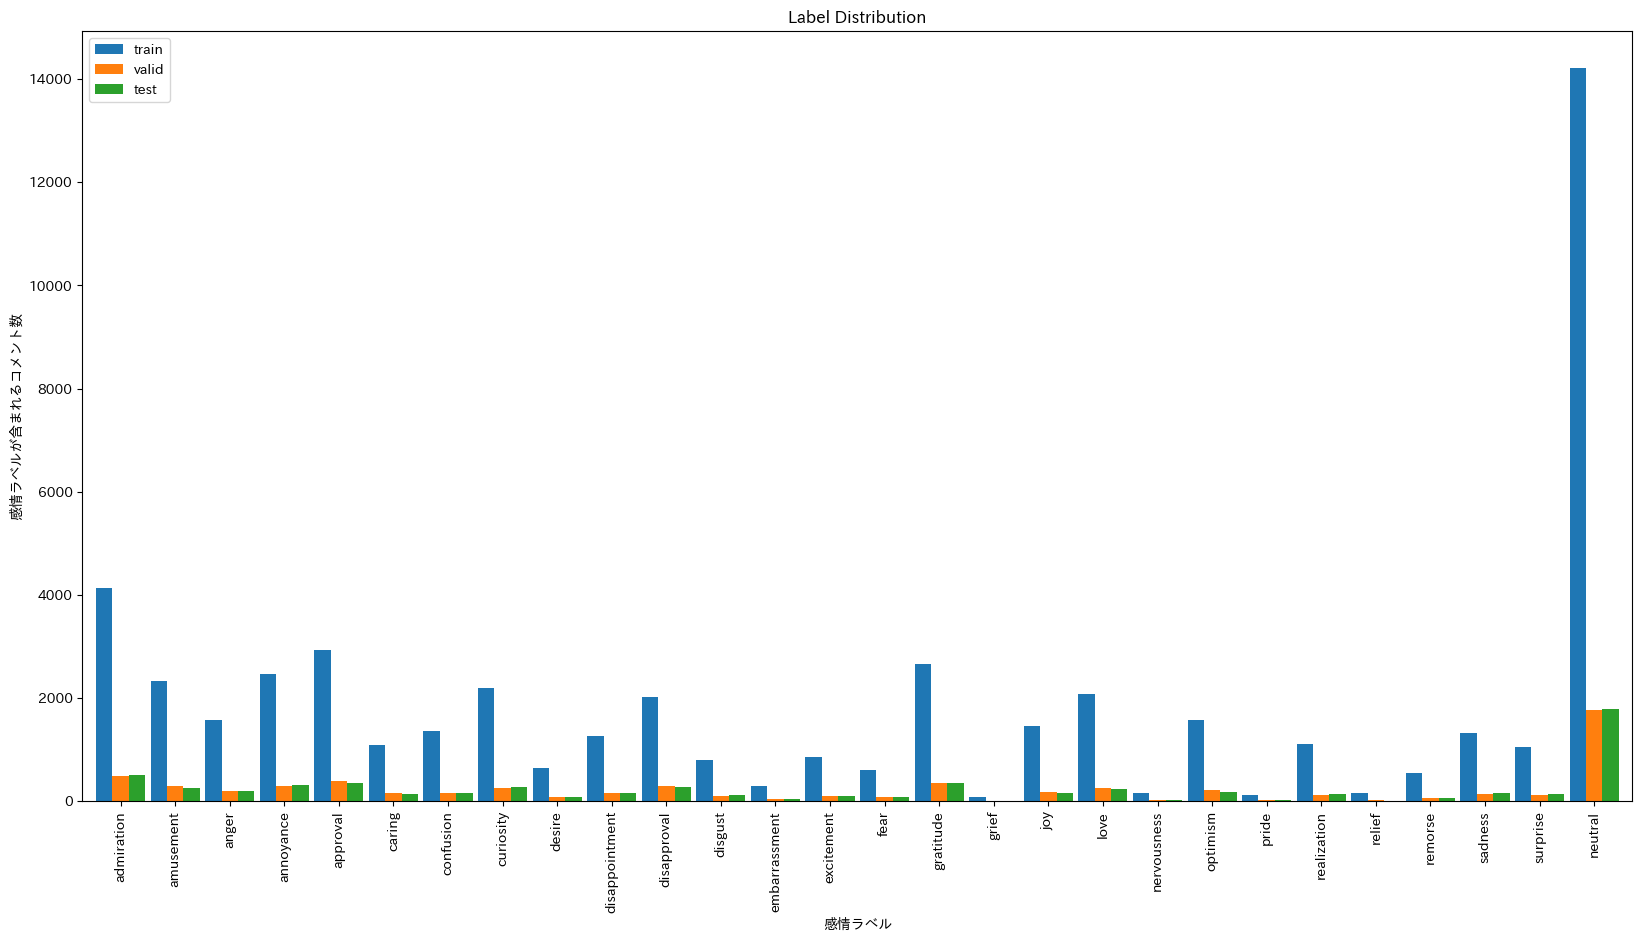

In [ ]:
# ラベルの分布を可視化
def plot_label_distribution(label_distribution_df) -> None:
    """
    ラベルの分布をヒストグラムで可視化する

    Args:
        label_distribution_df (pd.DataFrame): ラベルの出現数をまとめたDataFrame.
    """
    label_distribution_df = label_distribution_df.set_index("emotion")
    label_distribution_df.plot(kind="bar", figsize=(20, 10), width=0.9)
    plt.title("Label Distribution")
    plt.xlabel("感情ラベル")
    plt.ylabel("感情ラベルが含まれるコメント数")
    plt.rcParams["font.size"] = 16
    plt.show()

plot_label_distribution(label_distribution_df)

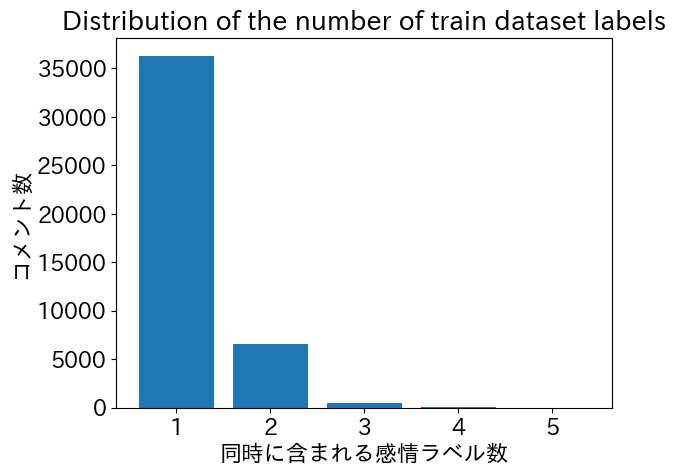

defaultdict(<class 'int'>, {1.0: 36308, 2.0: 6541, 3.0: 532, 4.0: 28, 5.0: 1})
{1.0: 0.836397143515319, 2.0: 0.1506795669200645, 3.0: 0.01225524072794287, 4.0: 0.00064501266989173, 5.0: 2.30361667818475e-05}


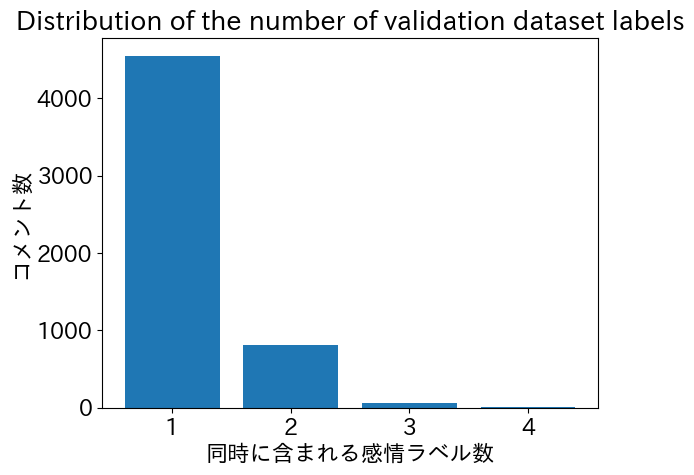

defaultdict(<class 'int'>, {1.0: 4548, 2.0: 809, 3.0: 62, 4.0: 7})
{1.0: 0.838186509399189, 2.0: 0.14909694065610027, 3.0: 0.01142646516771102, 4.0: 0.0012900847769996315}


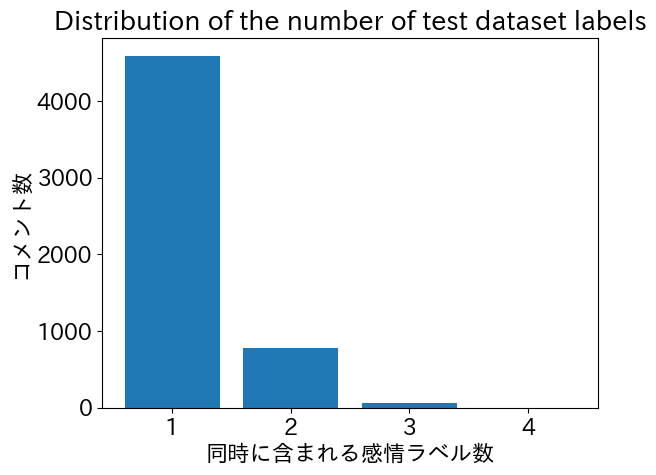

defaultdict(<class 'int'>, {1.0: 4590, 2.0: 774, 3.0: 61, 4.0: 2})
{1.0: 0.845771144278607, 2.0: 0.14262023217247097, 3.0: 0.011240095817210244, 4.0: 0.0003685277317118113}


In [ ]:
# コメントに同時に何個の感情ラベルがあるかをヒストグラムで確認する
def plot_label_distribution(tokenized_datasets, dataset_type="") -> None:
    """
    同時に付与されたラベル数をヒストグラムで可視化する

    Args:
        datasets: データセット
    """

    # ラベルの数をカウント
    label_count = defaultdict(int)
    for example in tokenized_datasets:
        label_count[sum(example["labels"])] += 1

    # ヒストグラムの描画
    plt.bar(label_count.keys(), label_count.values())
    plt.xlabel("同時に含まれる感情ラベル数")
    plt.ylabel("コメント数")
    plt.title(f"Distribution of the number of {dataset_type} dataset labels")
    plt.show()

    # ラベルの数を表示
    print(label_count)
    # ラベルの数の割合を表示
    print({k: v / len(tokenized_datasets) for k, v in label_count.items()})

plot_label_distribution(tokenized_train_datasets, "train")
plot_label_distribution(tokenized_valid_datasets, "validation")
plot_label_distribution(tokenized_test_datasets, "test")


## ファインチューニングの実装

事前準備ができたので、モデルをファインチューニングします。

### (1) 評価関数の定義

以下の関数にて、学習時に利用する評価指標の計算を行います。

In [ ]:
def multi_label_metrics(predictions: np.ndarray, labels: np.ndarray, threshold: float = 0.5) -> dict:
    """
    マルチラベル分類の評価指標を計算する

    Args:
        predictions (numpy.ndarray): 各ラベルの予測確率
        labels (numpy.ndarray): 正解ラベル
        threshold (float, optional): 確率を2値に変換するためのしきい値.初期値は0.5.

    Returns:
        dict: midro-F1,macro-F1,AUC,正解率を含む評価指標の辞書
    """

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    y_true = labels
    accuracy = accuracy_score(y_true, y_pred)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
    roc_auc = roc_auc_score(y_true, y_pred, average="micro")

    return {"micro_f1": f1_micro_average, "macro_f1": f1_macro_average, "roc_auc": roc_auc, "accuracy": accuracy}


def compute_metrics(p: EvalPrediction) -> dict:
    """
    マルチラベル分類の評価指標を用意する

    Args:
        p (EvalPrediction): クラスのインスタンス

    Returns:
        dict: 計算された指標を含む辞書
    """
    predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=predictions, labels=p.label_ids)
    return result


### (2) 学習条件の定義

学習の条件を設定するため、`TrainingArguments` クラスに各種条件を指定します。

In [ ]:
training_args = TrainingArguments(
    output_dir=TRAIN_LOG_OUTPUT,  # モデルの保存先
    num_train_epochs=30,  # エポック数
    learning_rate=1e-5,  # 学習率
    per_device_train_batch_size=32,  # 学習時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    weight_decay=0.01,  # 重み減衰
    save_strategy="epoch",  # モデルの保存タイミング
    logging_strategy="epoch",  # ログの出力タイミング
    evaluation_strategy="epoch",  # 評価のタイミング
    optim="adafactor",  # 最適化手法
    gradient_accumulation_steps=4,  # 勾配蓄積のステップ数
    load_best_model_at_end=True,  # 最良のモデルを最後に読み込むかどうか
    metric_for_best_model="macro_f1",  # 最良のモデルを判断する指標
    fp16=True,  # 16bit 精度を利用するかどうか
    overwrite_output_dir=True,  # 出力先のディレクトリを上書きするかどうか
)

### (3) ファインチューニングの実行

`trainer.train()` 関数を実行してファインチューニングを開始します。
Google Colab で T4 の GPU を選択した場合には約3時間ほど時間がかかります。

In [ ]:
trainer = Trainer(
    model=model,  # 利用するモデル
    args=training_args,  # 学習時の設定
    train_dataset=tokenized_train_datasets,  # 訓練データ
    eval_dataset=tokenized_valid_datasets,  # 評価データ
    tokenizer=tokenizer,  # トークナイザ
    data_collator=data_collator,  # データの前処理
    compute_metrics=compute_metrics,  # 評価指標の計算
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Roc Auc,Accuracy
0,0.245800,0.147695,0.008739,0.005181,0.502194,0.002396
1,0.136300,0.121291,0.398150,0.112618,0.633070,0.270734
2,0.115900,0.106175,0.446116,0.133814,0.655788,0.317177
4,0.097700,0.094216,0.513519,0.249712,0.693461,0.386104
5,0.093100,0.091150,0.520372,0.257025,0.696715,0.391264
6,0.089500,0.088694,0.547520,0.314525,0.713827,0.423701
8,0.084200,0.086262,0.552511,0.344765,0.718442,0.431994
9,0.082300,0.086691,0.554370,0.369303,0.722031,0.429598
10,0.080700,0.086074,0.562500,0.378073,0.727976,0.441762
12,0.077400,0.085978,0.568339,0.395513,0.736295,0.449687


TrainOutput(global_step=10170, training_loss=0.08476148378415328, metrics={'train_runtime': 2075.0244, 'train_samples_per_second': 627.607, 'train_steps_per_second': 4.901, 'total_flos': 1.2315067710620064e+16, 'train_loss': 0.08476148378415328, 'epoch': 29.98})

In [ ]:
# 評価指標の確認
eval_metrics = trainer.evaluate(tokenized_valid_datasets)

eval_metrics

{'eval_loss': 0.08859968185424805,
 'eval_micro_f1': 0.5675941665921087,
 'eval_macro_f1': 0.43786624826423687,
 'eval_roc_auc': 0.7430069908532044,
 'eval_accuracy': 0.45798009583486915,
 'eval_runtime': 2.3393,
 'eval_samples_per_second': 2319.547,
 'eval_steps_per_second': 72.673,
 'epoch': 29.98}

### (4) モデルの保存

次のコードを実行してファインチューニング済みのモデルを保存します。

In [ ]:
# モデルの保存
trainer.save_model(MODEL_OUTPUT)